# Géneros musicales

### Descripción

Se pide un modelo generativo que pueda predecir el género de una canción a patir de su letra.

Para esto, se trabajará con una serie de archivos con registros sobre letras musicales de distintos artistas, en la cual existen 4 géneros musicales (Rock, Hip-Hop, Metal, Pop). Dado que en este caso la clasificación no es binaria, utilizaremos el algoritmo **Multinomial Naive Bayes Classifier**.

## Preparar el ambiente de trabajo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# para la importación de archivos
import glob
import os

Queremos generar un array con los path absolutos de todos los archivos de la carpeta $\textsf{dump}$. Usamos $\textsf{glob}$ para obtener las direcciones locales y $\textsf{getcwd}$ para agregar la locación absoluta.

In [2]:
path_local = glob.glob("dump/*.csv")

path_abs = []
for i in path_local:
    path_abs.append(os.getcwd() + "/" + i)

Finalmente se ve como esto:

In [3]:
path_abs[:3]

['/home/cote/Documents/material_estudio_coding/courses/DATA_SCIENCE/DESAFIO_LATAM_DATA_SCIENCE/03_machine_learning/desafios/semana2/desafio1/Desafio_naive_bayes_MariaJosePozoM/dump/bruce_springsteen_scrape.csv',
 '/home/cote/Documents/material_estudio_coding/courses/DATA_SCIENCE/DESAFIO_LATAM_DATA_SCIENCE/03_machine_learning/desafios/semana2/desafio1/Desafio_naive_bayes_MariaJosePozoM/dump/lorde_scrape.csv',
 '/home/cote/Documents/material_estudio_coding/courses/DATA_SCIENCE/DESAFIO_LATAM_DATA_SCIENCE/03_machine_learning/desafios/semana2/desafio1/Desafio_naive_bayes_MariaJosePozoM/dump/the_clash_scrape.csv']

Definimos un $\textsf{df}$ para cada path y los concatenamos en uno solo. Dejamos la columna $\tt{Unnamed: 0}$ fuera.

In [4]:
arr_dfs = []

for i in range(len(path_abs)):
    df_i = pd.read_csv(path_abs[i])
    arr_dfs.append(df_i)

df_ = pd.concat(arr_dfs)

df = df_[["0", "1", "2", "3"]]

Recodificamos los nombres de las variables a algo más amigable.

In [6]:
recod = {"0": "artist",
         "1": "genre",
         "2": "title",
         "3": "lyric"}

df.rename(columns = recod, inplace = True)

Nos queda:

In [7]:
df.head()

artist genre                               title  \
0  Bruce Springsteen  rock                Blinded By The Light   
1  Bruce Springsteen  rock                          Growin' Up   
2  Bruce Springsteen  rock              Mary Queen Of Arkansas   
3  Bruce Springsteen  rock  Does This Bus Stop At 82nd Street?   
4  Bruce Springsteen  rock                   Lost In The Flood   

                                               lyric  
0  Madman drummers bummers and Indians in the sum...  
1  Well I stood stone-like at midnight \n Suspend...  
2  Mary Queen of Arkansas, it's not too early for...  
3  Hey bus driver, keep the change \n Bless your ...  
4  The ragamuffin gunner is returnin' home like a...

## Descripción de los datos

#### Cantidad de canciones registradas por cada artista, ordenado de mayor a menor

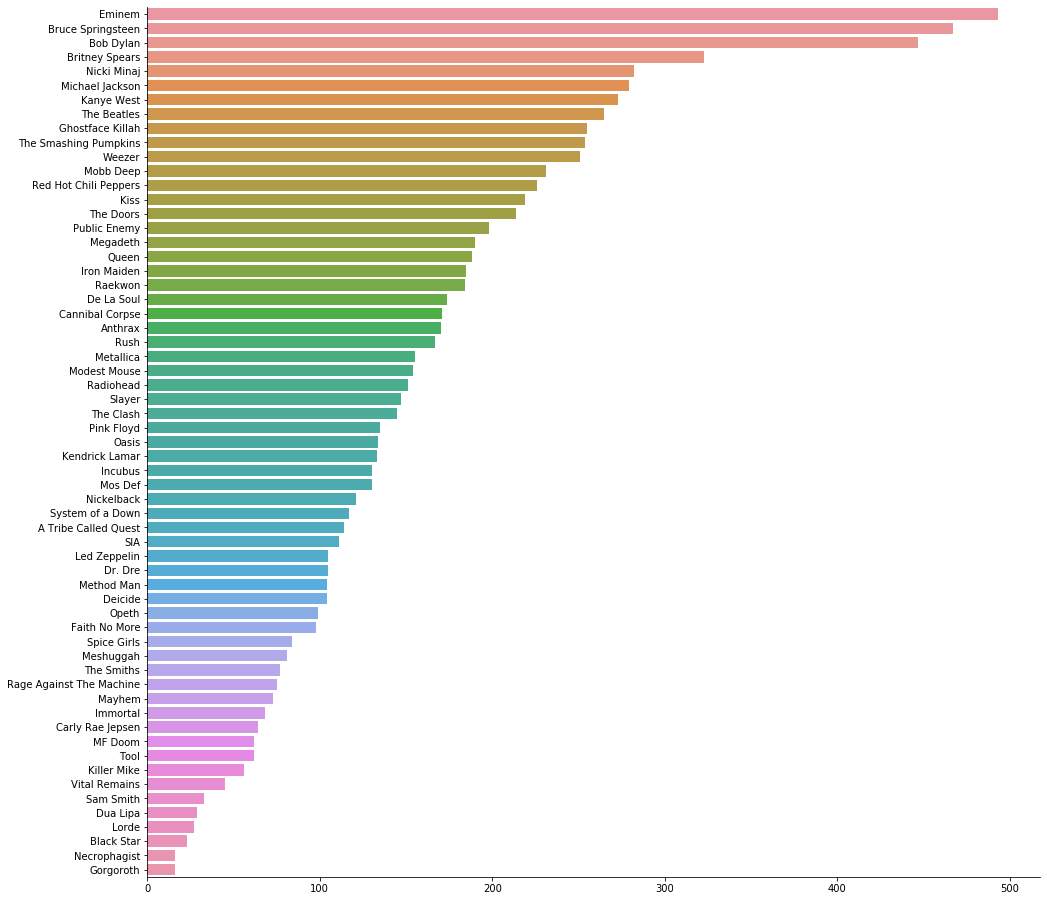

In [8]:
plt.figure(figsize = (16, 16))

sns.countplot(y = df['artist'], order = df['artist'].value_counts().index);
plt.xlabel("")
plt.ylabel("")

sns.despine()

#### Cantidad de canciones registradas en cada género, ordenados de mayor a menor

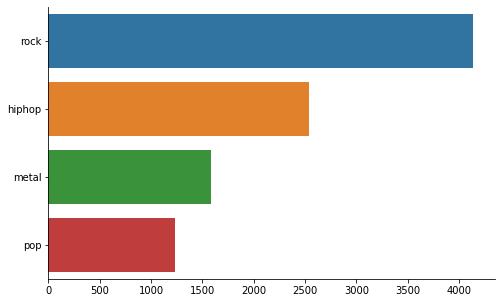

In [9]:
plt.figure(figsize = (8, 5))

sns.countplot(y = df['genre'], order = df['genre'].value_counts().index);
plt.xlabel("")
plt.ylabel("")

sns.despine()

Observamos que entre $\sf{Eminem}$, $\sf{Bruce\ Springsteen}$ y $\sf{Bob \ Dylan}$ abarcan ampliamente la mayoría de registros. $\sf{Eminem}$ pertenece al género $\sf{hip-hop}$ mientras que los otros dos a $\sf{rock}$, lo que puede influir en que las categorías con más datos sean justamente esas dos.

## Matriz de ocurrencias

Utilizaremos la clase $\tt{CountVectorizer}$ para el proceso de tokenización.

Aplicamos la clase para extraer las $100$ palabras más repetidas en todo el dataframe.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words = 'english', max_features = 100)
count_vectorizer_fit = count_vectorizer.fit_transform(df['lyric'])

# extraemos los tokens (palabras)
words100 = count_vectorizer.get_feature_names()

# extraemos sus frecuencias
words100_freq = count_vectorizer_fit.toarray().sum(axis = 0)

Las últimas $10$ palabras más repetidas y sus respectivas frecuencias:

In [11]:
most_freq_words = list(zip(words100, words100_freq))
most_freq_words[-10:]

[('uh', 2146),
 ('ve', 5924),
 ('wanna', 5356),
 ('want', 6698),
 ('way', 5713),
 ('won', 3161),
 ('world', 4106),
 ('ya', 4222),
 ('yeah', 11071),
 ('yo', 4859)]

Generamos una función que replique el procesamiento para cada uno de los géneros.

In [12]:
def frequent_words(dataframe, variable, groupby, category, idiom = 'english', freq = 100):
    count_vectorizer = CountVectorizer(stop_words = idiom, max_features = freq)
    count_vectorizer_fit = count_vectorizer.fit_transform(dataframe[dataframe[groupby] == category][variable])
    w100 = count_vectorizer.get_feature_names()
    w100_freq = count_vectorizer_fit.toarray().sum(axis = 0)
    most_freq_words = list(zip(w100, w100_freq))
    
    return most_freq_words

In [13]:
rock_genre = frequent_words(df, "lyric", "genre", "rock")
hiphop_genre = frequent_words(df, "lyric", "genre", "hiphop")
metal_genre = frequent_words(df, "lyric", "genre", "metal")
pop_genre = frequent_words(df, "lyric", "genre", "pop")

Revisemos las $10$ palabras más repetidas para cada género.

In [14]:
sorted_rock = sorted(rock_genre, key = lambda tup: tup[1], reverse = True)
sorted_hiphop = sorted(hiphop_genre, key = lambda tup: tup[1], reverse = True)
sorted_metal = sorted(metal_genre, key = lambda tup: tup[1], reverse = True)
sorted_pop = sorted(pop_genre, key = lambda tup: tup[1], reverse = True)

top_rock, top_hiphop, top_metal, top_pop = [], [], [], []

for i in range(100):
    top_rock.append(sorted_rock[i][0])
    top_hiphop.append(sorted_hiphop[i][0])
    top_metal.append(sorted_metal[i][0])
    top_pop.append(sorted_pop[i][0])

In [15]:
print(f"rock: {top_rock[:50]}\n")
print(f"hiphop: {top_hiphop[:50]}\n")
print(f"metal: {top_metal[:50]}\n")
print(f"pop: {top_pop[:50]}\n")

rock: ['don', 'love', 'know', 'oh', 'yeah', 'just', 'got', 'll', 'like', 've', 'come', 'time', 'baby', 'gonna', 'let', 'want', 'say', 'way', 'man', 'away', 'right', 'make', 'night', 'day', 'cause', 'hey', 'feel', 'life', 'little', 'need', 'said', 'ooh', 'world', 'good', 'tell', 'heart', 'wanna', 'long', 'girl', 'ain', 'ah', 'won', 'home', 'eyes', 'look', 'think', 'la', 'mind', 'tonight', 'light']

hiphop: ['like', 'got', 'don', 'know', 'just', 'shit', 'ain', 'cause', 'man', 'yo', 'yeah', 'nigga', 'fuck', 'let', 'll', 'make', 'em', 'come', 'time', 'right', 'say', 'love', 'ya', 'niggas', 'oh', 'want', 'wanna', 'life', 'bitch', 'ass', 'real', 'way', 'tell', 'need', 'niggaz', 'black', 'baby', 'think', 'new', 'look', 'good', 'gotta', 'feel', 'said', 'little', 'hit', 'people', 'uh', 'money', 'day']

metal: ['life', 'don', 'death', 'time', 'll', 'know', 'just', 'blood', 'like', 'die', 've', 'god', 'away', 'dead', 'eyes', 'way', 'world', 'come', 'hell', 'yeah', 'end', 'pain', 'kill', 'mind', '

* Rock: Se observan mayormente palabras asociadas al amor y filosofías de vida.
* Hip Hop: Se observa mucho improperio y palabras alusivas a su cultura de barrio.
* Metal: En su mayoría son palabras asociadas a temas oscuros (muerte, dolor, sufrimiento, etc.).
* Pop: Repite bastante patrones del Rock, pero de forma un poco más superficial.

## Entrenamiento del Modelo

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# para la matriz de confusión
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

Generamos los conjuntos de entrenamiento y prueba.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['lyric'], df['genre'], test_size = .4, random_state = 2702)

Utilizamos $\tt{Pipeline}$ para concatenar la tokenización y la modelación con $\tt{multinomialNB}$.

In [18]:
pipeline_model = Pipeline([('count_vectorize', CountVectorizer()),
                           ('multiNB', MultinomialNB())])

pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('count_vectorize', CountVectorizer()),
                ('multiNB', MultinomialNB())])

### Predicción con una lista con letras de canciones aleatorias

In [19]:
lyrics_list = ["I got a place in the underworld", # Brody Dalle - Underworld
"As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara", # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
"Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way", # Ludacris - Move B*tch
"Sexual violence doesn't start and end with rape It starts in our books and behind our school gates", # IDLES - Mother
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to \
build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting\
You are not deserving, you are not deserving" #Banks - Drowning
]

In [20]:
ypred_lyrics = pipeline_model.predict(lyrics_list)

In [21]:
print(f"Géneros predichos: {ypred_lyrics}")

Géneros predichos: ['rock' 'metal' 'rock' 'hiphop' 'metal' 'rock']


### Predicción con la muestra de test

In [22]:
y_predict = pipeline_model.predict(X_test)

Contrastemos las predicciones del modelo con la matriz de confusión.

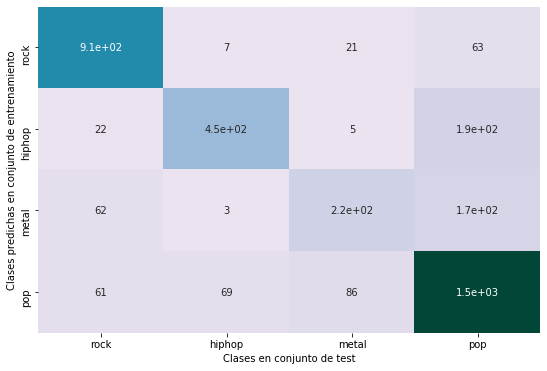

In [23]:
color_palette_sequential = [ '#ece3f0', '#d0d1e6', '#a6bddb', '#67a9cf', '#3690c0', '#02818a', '#016c59', '#014636']
plt.figure(figsize = (9, 6))

tmp_confused = confusion_matrix(y_test, y_predict)
custom_cmap = LinearSegmentedColormap.from_list('lista', color_palette_sequential)
sns.heatmap(tmp_confused, annot = True, cbar = False, cmap = custom_cmap,
            xticklabels = ["rock", "hiphop", "metal", "pop"],
            yticklabels = ["rock", "hiphop", "metal", "pop"])
plt.xlabel('Clases en conjunto de test')
plt.ylabel('Clases predichas en conjunto de entrenamiento')
plt.grid(False)

Lo primero que salta a la vista es el problema del modelo para predecir la clase $\sf{pop}$, puesto que en comparación con los falsos negativos de las otras clases, hay una cantidad considerablemente mayor.

Estudiamos las métricas:

In [24]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

      hiphop       0.86      0.91      0.89      1002
       metal       0.85      0.67      0.75       673
         pop       0.66      0.48      0.55       453
        rock       0.77      0.87      0.82      1668

    accuracy                           0.80      3796
   macro avg       0.79      0.73      0.75      3796
weighted avg       0.80      0.80      0.79      3796



Tal como se observaba en la matriz de confusión, la clase $\sf{pop}$ es la que presenta peores métricas. La cantidad de etiquetas correctamente asignadas en su nombre ($\sf{precision}$) no es tan alto ($66\%$), mientras que su $\sf{recall}$ de $48\%$ nos muestra que en menos de la mitad de los casos esta clase está correctamente predicha (verdaderos positivos). Esto se da por la baja cantidad de registros de esta clase en comparación a las otras.

El resto de las clases en cambio da un indicio de que el modelo cumple bastante bien hasta cierto punto. $\sf{hiphop}$ y $\sf{rock}$ tienen un buen $\sf{recall}$ y un $\sf{precision}$ no bajo. Quiere decir que el modelo predice correctamente las clases $\sf{hiphop}$ y $\sf{rock}$ con un $\sf{recall}$ de $91\%$ y $87\%$, respectivamente, y también con sus correspondientes $\sf{precision}$ ($86\%$ y $77\%$) vemos que el modelo se equivoca poco.

Con la clase $\sf{metal}$ el desempeño decae un poco más. Tiene un buen $\sf{precision}$ ($85\%$), sin embargo, su $\sf{recall}$ de $67\%$ indica un número no menor de falsos negativos.

Por último, en cuanto al desempeño general del modelo ($\sf{f1-score}$) vemos valores bastante altos en $\sf{hiphop}$ y $\sf{rock}$ ($89\%$ y $82\%$, respectivamente), pues sus $\sf{precision}$ y $\sf{recall}$ son altos y son las clases con mayor cantidad de registros en el dataset de entrenamiento. $\sf{metal}$ no tiene un desempeño general bajo, pero tampoco alto ($75\%$) y en cuanto a $\sf{pop}$ se esperaba que no fuera bueno ($55\%$), dado su $\sf{recall}$ bajo.

## Mejora del Modelo

Las clases con peores métricas resultaron ser $\sf{pop}$ y $\sf{metal}$. Intentaremos mejorar los resultados ajustando los hiperparámetros del clasificador $\tt{MultinomialNB}$, específicamente el parámetro $\textsf{class_prior}$.

Definimos un nuevo $\tt{Pipeline}$. Esta vez el clasificador le asignará a todas las clases la misma probabilidad a priori ($0.25$).

In [25]:
pipeline_refact = Pipeline([('count_vectorize', CountVectorizer()),
                           ('multiNB', MultinomialNB(class_prior = [0.25, 0.25, 0.25, 0.25]))])

pipeline_refact.fit(X_train, y_train)

Pipeline(steps=[('count_vectorize', CountVectorizer()),
                ('multiNB',
                 MultinomialNB(class_prior=[0.25, 0.25, 0.25, 0.25]))])

In [26]:
ypred_refact = pipeline_refact.predict(X_test)

In [27]:
print(classification_report(y_test, ypred_refact))

              precision    recall  f1-score   support

      hiphop       0.86      0.91      0.89      1002
       metal       0.85      0.68      0.75       673
         pop       0.64      0.49      0.56       453
        rock       0.78      0.86      0.82      1668

    accuracy                           0.80      3796
   macro avg       0.78      0.74      0.75      3796
weighted avg       0.80      0.80      0.79      3796



Vemos que los resultados no cambian demasiado al modelo original.

La clase $\sf{hiphop}$ se mantuvo sin cambios, mientras que $\sf{rock}$ mejoró levemente su $\sf{precision}$ a cambio de otra leve baja en su $\sf{recall}$.

También, aunque con cambios leves, efectivamente $\sf{metal}$ y $\sf{pop}$ mejoraron sus $\sf{recall}$ (de $67\%$ a $68\%$ y de $48\%$ a $49\%$, respectivamente), aunque hubo una baja en la precisión para $\sf{pop}$ (de $66\%$ a $64\%$).

También hubo un alza mínima en el desempeño general del modelo ($\sf{f1-score}$) para $\sf{pop}$ (de $55\%$ a $56\%$).